In [ ]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
from tqdm.notebook import tqdm_notebook
import copy

Importing data:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/DeepLearning/HW3/Q1 Materials'
Data_org = pd.read_csv(path+'/BBBP.csv')
Data_org.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print('device = ', device)
dtype = torch.float

device =  cuda


# Part A
Analyzing BBBP data set

This dataset contains 4 Columns. 'name' shows each molecule name and 'num' shows their number in the dataset.(It has 2053 molecules.)

'smiles' describes their molecular structure using SMILE(Simplified molecular-input line-entry system) format which is an array of characters in type of 'string'.I have analyzed this column in this section to have a better view of the dataset.

And 'p_np' contains our class labels. we have two classes labeled by {0,1}.

And the task is to classify each molecule by Its smile representation.

##Tokenizing:

In [ ]:
smiles = Data_org['smiles']

In this work, we have tokenized each smile array in character level. All Atoms In SNILE representation of molecules in this dataset are {'H', 'c', 'C', 'n', 'N', 'P', 's', 'S', 'o', 'O', 'Br', 'Na', 'Ca', 'F', 'I', 'Cl', 'B'}.

You can see all 40 tokens stored in the smile_cats variable in the cell below:

In [ ]:
all_smiles = '|'.join(smiles)

In [ ]:
smiles_cats = set(all_smiles)
smiles_cats.remove('|')
smiles_cats.remove('r')
smiles_cats.remove('a')
smiles_cats.remove('l')
smiles_cats.add('Na')
smiles_cats.add('Ca')
smiles_cats.add('Br')
smiles_cats.add('Cl')
Atoms = {'c', 'C', 'n', 'N', 'P', 's', 'S', 'o', 'O', 'Br', 'Na', 'Ca', 'F', 'I', 'Cl', 'B'}
print(smiles_cats)

{'Ca', 's', '/', '(', '7', '3', 'c', '+', 'o', 'O', 'H', 'n', 'B', 'S', '=', '9', '%', ')', ']', '4', 'F', '-', '[', '2', '@', '6', '0', '5', '1', 'P', 'Na', 'I', 'N', '.', 'Cl', 'Br', '8', 'C', '#', '\\'}


To make it easier to work with, we replaced 'Cl', 'Ca', 'Na, and 'Br' with 'l', 'd', 'a', and 'r' to have all tokens in the length of 1.

New tokens are stored in 'new_smiles_cats'.

In [ ]:
all_smiles = all_smiles.split('Cl')
all_smiles = 'l'.join(all_smiles)
all_smiles = all_smiles.split('Ca')
all_smiles = 'd'.join(all_smiles)
all_smiles = all_smiles.split('Na')
all_smiles = 'a'.join(all_smiles)
all_smiles = all_smiles.split('Br')
all_smiles = 'r'.join(all_smiles)

In [ ]:
new_smiles_cats = set(all_smiles)
new_smiles_cats.remove('|')
new_Atoms = {'c', 'C', 'n', 'N', 'P', 's', 'S', 'o', 'O', 'r', 'a', 'd', 'F', 'I', 'l', 'B'}
print(new_smiles_cats)

{'s', '/', '(', '7', '3', 'c', '+', 'o', 'O', 'H', 'n', 'B', 'S', '=', '9', 'd', '%', ')', ']', 'r', '4', 'F', '-', '[', '2', '@', '6', '0', '5', '1', 'l', 'P', 'I', 'N', 'a', '.', '8', 'C', '#', '\\'}


##Analyzing the length of molecules
We have analyzed the distribution of the length of molecules in two ways. At first, we have indicated the distribution of the number of Atoms (except Hydrosion) in each molecule structure, and second distribution of the number of tokens is plotted.

Maximum length of tokens is 400.

In [ ]:
only_atoms = list(all_smiles)
only_atoms = np.array(only_atoms)
for c in new_smiles_cats-new_Atoms.union({'|'}):
  only_atoms = only_atoms[only_atoms != c]
only_atoms = ''.join(only_atoms)
where_to_break = np.arange(len(only_atoms)+2)[np.array(['|']+list(only_atoms)+['|']) == '|']
len_atoms = where_to_break[1:]- where_to_break[:-1] - 1

In [ ]:
where_to_break = np.arange(len(all_smiles)+2)[np.array(['|']+list(all_smiles)+['|']) == '|']
len_smiles = where_to_break[1:]- where_to_break[:-1] - 1

In [ ]:
new_smiles = all_smiles.split('|')

In [ ]:
max_len = max(len_smiles)
max_len

400

Text(0.5, 1.0, 'Distribution of number of tokens')

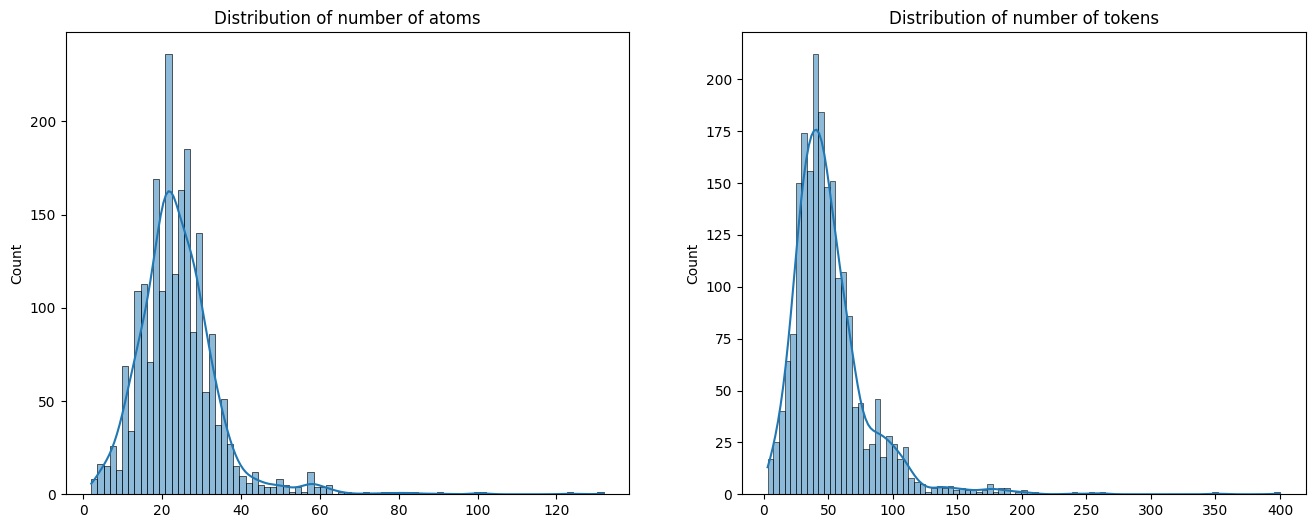

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(1 ,2, figsize=(16, 6))
sns.histplot(len_atoms, kde = True, ax= ax[0]).set_title('Distribution of number of atoms')
sns.histplot(len_smiles, kde= True, ax= ax[1]).set_title('Distribution of number of tokens')

##Frequency of occurrence of tokens
Plot below shows how many times each token is used during all molecules.

As indicated in the diagram, 'C' is most used token because of importance of atom Carbon which is represented by 'C' and 'c' in tokens. and 'Ca' and 'B' are used only one time in all smiles.

In [ ]:
smile_array = np.array(list(all_smiles))
diff = {'d':'Ca', 'a': 'Na', 'r':'Br', 'l':'Cl'}
freq = {}
for token in new_smiles_cats:
  token_pr = token
  if(token in diff.keys()):
    token_pr = diff[token]
  freq[token_pr] = np.sum(smile_array == token)

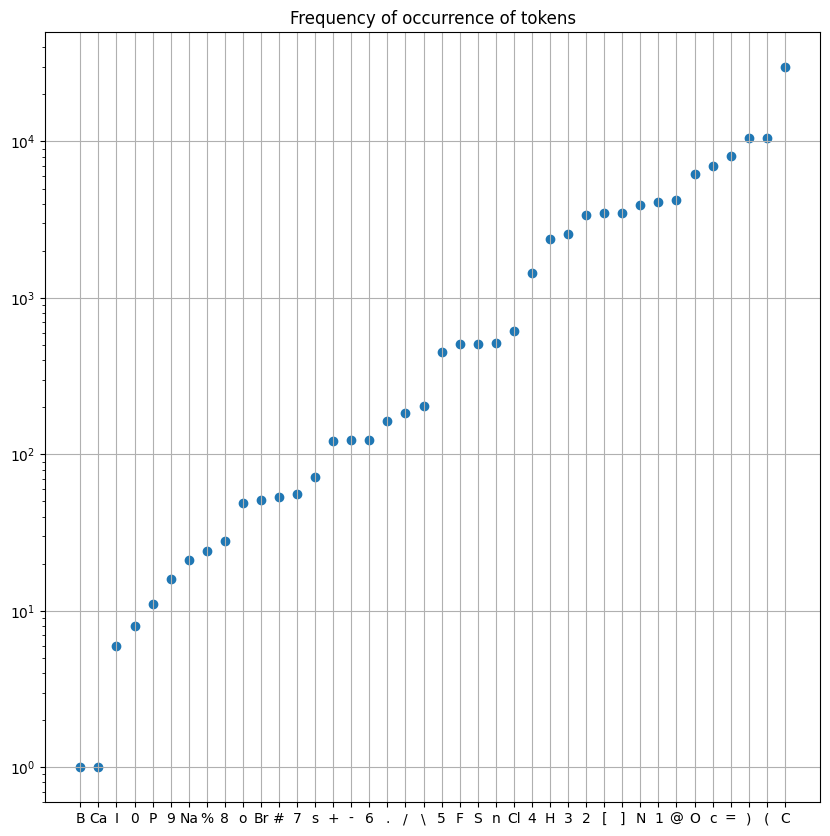

In [ ]:
idx = np.argsort(list(freq.values()), )
plt.figure(figsize = (10,10))
plt.scatter(np.array(list(freq.keys()))[idx], np.array(list(freq.values()))[idx])
plt.title('Frequency of occurrence of tokens')
plt.yscale('log')
plt.grid()

# Part **B**

Vectorizing Data and training a FC layer for baseline

## Building dataset

### Vectorizing data

Padding to have all vectors with same length of 400:

In [ ]:
for i in range(len(smiles)):
  new_smiles[i] = list(new_smiles[i])+ (max_len - len_smiles[i])* ['pad']

Building final dataset of shape (2053,40,400) by noe_hot encoding : (stored in 'Data')

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop= ['pad']*max_len, sparse_output= False)
encoder.fit(np.array([list(new_smiles_cats)+['pad']]*max_len).T)
data = encoder.transform(np.array(new_smiles))

In [ ]:
data = data.reshape((len(len_smiles), max_len, -1))
data = np.transpose(data, (0,2,1))

###Building torch dataset and data loaders for train, validation and test:

In [ ]:
class bbbp_dataset(Dataset):
    def __init__(self, data, labels, len_smiles, shuffle = True):
        """
        Documentation here:
        num_examples is the number of examples we want this dataset to have
        x_range is a tuple of (lowest_possible_x, highest_possible_x)
        """
        self.num_data = len(labels)
        if(shuffle):
          idxs = np.random.choice(self.num_data, self.num_data, replace = False)
          self.data = data[idxs]
          self.targets = list(np.array(labels)[idxs])
        else:
          self.data = data.clone()
          self.targets = labels.copy()

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx], len_smiles[idx]

    def __len__(self):
        return self.num_data

In [ ]:
BBBP_data = bbbp_dataset(torch.from_numpy(data), list(Data_org['p_np']), torch.from_numpy(len_smiles))
loader_train = DataLoader(BBBP_data, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(int(BBBP_data.num_data*0.8*0.8))))
loader_valid = DataLoader(BBBP_data, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(int(BBBP_data.num_data*0.8*0.8), int(BBBP_data.num_data*0.8))))
loader_test = DataLoader(BBBP_data, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(int(BBBP_data.num_data*0.8), BBBP_data.num_data)))

## Defining and traing the FC layer:

In [ ]:
class FC_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # forward always defines connectivity
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

NameError: name 'nn' is not defined

In [ ]:
def check_accuracy(loader, model, print_result = False, stage= 'validation'):
  num_correct = 0
  num_samples = 0
  loss = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y, _ in loader:
      x ,y =  x.reshape((len(x),-1)).to(device= device, dtype = dtype), y.to(device)
      scores = model(x)
      loss_batch = nn.functional.cross_entropy(scores, y)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
      loss += loss_batch * preds.size(0)
    acc = float(num_correct) / num_samples
    loss = loss / num_samples
    if(print_result):
      print(f'for {stage} dataset: accuracy = %.2f%% (Got {num_correct} / {num_samples}) correct and loss = {loss}' % (100*acc))
  return acc, loss.item()

In [ ]:
def train_model(model, loader_train, valid_loader, epochs, lr = 1e-3):
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  num_batches = len(loader_train)
  val_result = []
  train_result = []
  models = []
  for epoch in range(epochs):
    model.to(device)
    batches = tqdm_notebook(enumerate(loader_train), total= num_batches, desc= f'epoch {epoch} : ')
    for t, (x,y,_) in batches:
      model.train()
      x ,y = x.reshape((len(x),-1)).to(device= device, dtype = dtype), y.to(device)
      scores = model(x)
      loss = nn.functional.cross_entropy(scores, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    train_result.append(check_accuracy(loader_train, model, print_result= True, stage = 'train'))
    val_result.append(check_accuracy(valid_loader, model, print_result= True))
    models.append(copy.deepcopy(model).to('cpu'))
    print()
  return train_result, val_result, models

A FC_model with 2 hidden layers is deifined.(first Liear layer has relu activation function.)

input size == 1600

hidden_size == 400

output size == 2 (of cource it could be 1)

In [ ]:
fc_model = FC_model(data.shape[1]*data.shape[2], 400, 2)

training the model:

In [ ]:
train_result, val_result, models = train_model(fc_model, loader_train, loader_valid, epochs = 10, lr = 5e-4)

epoch 0 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 84.60% (Got 1110 / 1312) correct and loss = 0.3616843819618225
for validation dataset: accuracy = 85.67% (Got 281 / 328) correct and loss = 0.3475531041622162



epoch 1 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 91.69% (Got 1203 / 1312) correct and loss = 0.2216033637523651
for validation dataset: accuracy = 88.41% (Got 290 / 328) correct and loss = 0.27001163363456726



epoch 2 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 95.43% (Got 1252 / 1312) correct and loss = 0.15023508667945862
for validation dataset: accuracy = 91.16% (Got 299 / 328) correct and loss = 0.2727660536766052



epoch 3 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 96.57% (Got 1267 / 1312) correct and loss = 0.10458026081323624
for validation dataset: accuracy = 90.55% (Got 297 / 328) correct and loss = 0.27625423669815063



epoch 4 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 98.09% (Got 1287 / 1312) correct and loss = 0.07858029007911682
for validation dataset: accuracy = 90.24% (Got 296 / 328) correct and loss = 0.29698893427848816



epoch 5 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 98.70% (Got 1295 / 1312) correct and loss = 0.059765011072158813
for validation dataset: accuracy = 90.85% (Got 298 / 328) correct and loss = 0.30818483233451843



epoch 6 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 99.09% (Got 1300 / 1312) correct and loss = 0.04660649970173836
for validation dataset: accuracy = 89.94% (Got 295 / 328) correct and loss = 0.3353656828403473



epoch 7 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 99.24% (Got 1302 / 1312) correct and loss = 0.03710215538740158
for validation dataset: accuracy = 89.33% (Got 293 / 328) correct and loss = 0.3513011932373047



epoch 8 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 99.39% (Got 1304 / 1312) correct and loss = 0.029691271483898163
for validation dataset: accuracy = 89.02% (Got 292 / 328) correct and loss = 0.3779945373535156



epoch 9 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 99.62% (Got 1307 / 1312) correct and loss = 0.024044733494520187
for validation dataset: accuracy = 89.94% (Got 295 / 328) correct and loss = 0.39214611053466797



finding best model by comparisening their validation accuracy and checjing its accuracy on test data which is 85.6%.

In [ ]:
best_index = np.argmax(np.array(val_result)[:,0])
best_fc_model = models[best_index].to(device)
check_accuracy(loader_test, best_fc_model, print_result= True, stage = 'test')

for test dataset: accuracy = 85.61% (Got 351 / 410) correct and loss = 0.29393190145492554


(0.8560975609756097, 0.29393190145492554)

#Part C
Trainig an LSTM model:

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self, LSTM_input_size, hidden_size, num_classes, bidirectional = False):
        super().__init__()
        # assign layer objects to class attributes
        self.hidden_size = hidden_size
        self.Bidirectional = bidirectional
        self.RNN = nn.LSTM(LSTM_input_size, hidden_size, batch_first= True, bidirectional= bidirectional)
        if bidirectional: # we'll have 2 more layers
          self.fc = nn.Linear(hidden_size*2, num_classes)
        else:
          self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, device = device):
        # forward always defines connectivity
        if(self.Bidirectional):
          h_0 = torch.zeros((2, len(x), self.hidden_size), device = device)
          c_0 = torch.zeros((2, len(x), self.hidden_size), device = device)
        else:
          h_0 = torch.zeros((1, len(x), self.hidden_size), device = device)
          c_0 = torch.zeros((1, len(x), self.hidden_size), device = device)
        out, (hn, cn) = self.RNN(x, (h_0, c_0))
        if(self.Bidirectional):
          scores = self.fc(torch.cat((hn[0], hn[1]), dim=1))
        else:
          scores = self.fc(hn[0])
        return scores

In [ ]:
def check_lstm_accuracy(loader, model, print_result = False, stage= 'validation'):
  num_correct = 0
  num_samples = 0
  loss = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y, _ in loader:
      x ,y = x.to(device= device, dtype = dtype), y.to(device)
      scores = model(x)
      loss_batch = nn.functional.cross_entropy(scores, y)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
      loss += loss_batch * preds.size(0)
    acc = float(num_correct) / num_samples
    loss = loss / num_samples
    if(print_result):
      print(f'for {stage} dataset: accuracy = %.2f%% (Got {num_correct} / {num_samples} correct) and loss = {loss}' % (100*acc))
  return acc, loss.item()

In [ ]:
def train_lstm_model(model, loader_train, valid_loader, epochs, lr = 1e-3):
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  num_batches = len(loader_train)
  val_result = []
  train_result = []
  models = []
  for epoch in range(epochs):
    model.to(device)
    batches = tqdm_notebook(enumerate(loader_train), total= num_batches, desc= f'epoch {epoch} : ')
    for t, (x,y,_) in batches:
      model.train()
      x ,y = x.to(device= device, dtype = dtype), y.to(device)
      scores = model(x)
      loss = nn.functional.cross_entropy(scores, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    train_result.append(check_lstm_accuracy(loader_train, model, print_result= True, stage = 'train'))
    val_result.append(check_lstm_accuracy(valid_loader, model, print_result= True))
    models.append(copy.deepcopy(model).to('cpu'))
    print()
  return train_result, val_result, models

A model with one, one directional LSTM and one FC layer is defined:

for LSTM:

sequence length = 40

input size = 400

hidden size = 200

for FC layer:

input size = 200

ouput size = 2

In [ ]:
lstm_model = LSTM_model(400, 200, 2)

trainig the model for 30 epochs:

In [ ]:
train_result, val_result, models = train_lstm_model(lstm_model, loader_train, loader_valid, epochs = 30, lr = 5e-4)

epoch 0 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 75.53% (Got 991 / 1312 correct) and loss = 0.543620765209198
for validation dataset: accuracy = 81.40% (Got 267 / 328 correct) and loss = 0.47918689250946045



epoch 1 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 75.53% (Got 991 / 1312 correct) and loss = 0.5274596810340881
for validation dataset: accuracy = 81.40% (Got 267 / 328 correct) and loss = 0.47176769375801086



epoch 2 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 75.61% (Got 992 / 1312 correct) and loss = 0.4908201992511749
for validation dataset: accuracy = 81.40% (Got 267 / 328 correct) and loss = 0.4163837730884552



epoch 3 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 77.67% (Got 1019 / 1312 correct) and loss = 0.46409159898757935
for validation dataset: accuracy = 82.32% (Got 270 / 328 correct) and loss = 0.4256661832332611



epoch 4 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 80.64% (Got 1058 / 1312 correct) and loss = 0.38297680020332336
for validation dataset: accuracy = 84.76% (Got 278 / 328 correct) and loss = 0.32311561703681946



epoch 5 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 81.63% (Got 1071 / 1312 correct) and loss = 0.4180139899253845
for validation dataset: accuracy = 85.98% (Got 282 / 328 correct) and loss = 0.3401089906692505



epoch 6 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 83.46% (Got 1095 / 1312 correct) and loss = 0.3553216755390167
for validation dataset: accuracy = 86.59% (Got 284 / 328 correct) and loss = 0.3112553656101227



epoch 7 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 86.28% (Got 1132 / 1312 correct) and loss = 0.3010753095149994
for validation dataset: accuracy = 89.33% (Got 293 / 328 correct) and loss = 0.27927204966545105



epoch 8 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 84.53% (Got 1109 / 1312 correct) and loss = 0.32738199830055237
for validation dataset: accuracy = 86.89% (Got 285 / 328 correct) and loss = 0.28702738881111145



epoch 9 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 86.97% (Got 1141 / 1312 correct) and loss = 0.2864978313446045
for validation dataset: accuracy = 89.63% (Got 294 / 328 correct) and loss = 0.25554847717285156



epoch 10 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 88.64% (Got 1163 / 1312 correct) and loss = 0.26825228333473206
for validation dataset: accuracy = 85.98% (Got 282 / 328 correct) and loss = 0.2801903784275055



epoch 11 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 89.41% (Got 1173 / 1312 correct) and loss = 0.24929533898830414
for validation dataset: accuracy = 89.02% (Got 292 / 328 correct) and loss = 0.2600398659706116



epoch 12 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 89.79% (Got 1178 / 1312 correct) and loss = 0.23373958468437195
for validation dataset: accuracy = 90.24% (Got 296 / 328 correct) and loss = 0.23840072751045227



epoch 13 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 90.93% (Got 1193 / 1312 correct) and loss = 0.2189950793981552
for validation dataset: accuracy = 88.72% (Got 291 / 328 correct) and loss = 0.25729066133499146



epoch 14 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 89.25% (Got 1171 / 1312 correct) and loss = 0.2582167685031891
for validation dataset: accuracy = 88.41% (Got 290 / 328 correct) and loss = 0.2765306830406189



epoch 15 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 90.02% (Got 1181 / 1312 correct) and loss = 0.23409217596054077
for validation dataset: accuracy = 90.24% (Got 296 / 328 correct) and loss = 0.2570154368877411



epoch 16 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 91.01% (Got 1194 / 1312 correct) and loss = 0.2139177769422531
for validation dataset: accuracy = 89.63% (Got 294 / 328 correct) and loss = 0.24721139669418335



epoch 17 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 91.69% (Got 1203 / 1312 correct) and loss = 0.20370827615261078
for validation dataset: accuracy = 89.33% (Got 293 / 328 correct) and loss = 0.24738061428070068



epoch 18 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 91.92% (Got 1206 / 1312 correct) and loss = 0.19636127352714539
for validation dataset: accuracy = 90.55% (Got 297 / 328 correct) and loss = 0.2508067190647125



epoch 19 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 92.07% (Got 1208 / 1312 correct) and loss = 0.18562082946300507
for validation dataset: accuracy = 90.55% (Got 297 / 328 correct) and loss = 0.2480134218931198



epoch 20 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 89.94% (Got 1180 / 1312 correct) and loss = 0.23165364563465118
for validation dataset: accuracy = 86.89% (Got 285 / 328 correct) and loss = 0.2993388772010803



epoch 21 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 92.30% (Got 1211 / 1312 correct) and loss = 0.18924126029014587
for validation dataset: accuracy = 88.72% (Got 291 / 328 correct) and loss = 0.27110952138900757



epoch 22 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 92.84% (Got 1218 / 1312 correct) and loss = 0.17584355175495148
for validation dataset: accuracy = 90.55% (Got 297 / 328 correct) and loss = 0.25169259309768677



epoch 23 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 92.38% (Got 1212 / 1312 correct) and loss = 0.17571903765201569
for validation dataset: accuracy = 89.63% (Got 294 / 328 correct) and loss = 0.24625734984874725



epoch 24 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 90.78% (Got 1191 / 1312 correct) and loss = 0.19604800641536713
for validation dataset: accuracy = 89.94% (Got 295 / 328 correct) and loss = 0.26093369722366333



epoch 25 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 92.61% (Got 1215 / 1312 correct) and loss = 0.1693882942199707
for validation dataset: accuracy = 89.94% (Got 295 / 328 correct) and loss = 0.27833595871925354



epoch 26 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 93.37% (Got 1225 / 1312 correct) and loss = 0.16651496291160583
for validation dataset: accuracy = 87.50% (Got 287 / 328 correct) and loss = 0.29804727435112



epoch 27 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 93.75% (Got 1230 / 1312 correct) and loss = 0.16094467043876648
for validation dataset: accuracy = 88.41% (Got 290 / 328 correct) and loss = 0.33612164855003357



epoch 28 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 93.75% (Got 1230 / 1312 correct) and loss = 0.16232548654079437
for validation dataset: accuracy = 88.72% (Got 291 / 328 correct) and loss = 0.33031538128852844



epoch 29 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 92.61% (Got 1215 / 1312 correct) and loss = 0.1627398282289505
for validation dataset: accuracy = 85.98% (Got 282 / 328 correct) and loss = 0.34824442863464355



finding best model by comparisening their validation accuracy and checking its accuracy on test data which is almost 86.6%.(1% more than baseline)

In [ ]:
best_index = np.argmax(np.array(val_result)[:,0])
best_lstm_model = models[best_index].to(device)
check_lstm_accuracy(loader_test, best_lstm_model, print_result= True, stage = 'test')

for test dataset: accuracy = 86.59% (Got 355 / 410 correct) and loss = 0.31323230266571045


(0.8658536585365854, 0.31323230266571045)

#Part D
Trainig a BLSTM:

In [ ]:
blstm_model = LSTM_model(400, 100, 2, bidirectional= True)

In [ ]:
train_result, val_result, models = train_lstm_model(blstm_model, loader_train, loader_valid, epochs = 40, lr = 5e-4)

epoch 0 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 75.53% (Got 991 / 1312 correct) and loss = 0.5754729509353638
for validation dataset: accuracy = 81.40% (Got 267 / 328 correct) and loss = 0.5360617637634277



epoch 1 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 75.53% (Got 991 / 1312 correct) and loss = 0.5416415333747864
for validation dataset: accuracy = 81.40% (Got 267 / 328 correct) and loss = 0.4862011969089508



epoch 2 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 75.53% (Got 991 / 1312 correct) and loss = 0.5166462063789368
for validation dataset: accuracy = 81.40% (Got 267 / 328 correct) and loss = 0.4422858953475952



epoch 3 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 75.69% (Got 993 / 1312 correct) and loss = 0.49060317873954773
for validation dataset: accuracy = 81.40% (Got 267 / 328 correct) and loss = 0.4350697994232178



epoch 4 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 76.22% (Got 1000 / 1312 correct) and loss = 0.4687272310256958
for validation dataset: accuracy = 81.71% (Got 268 / 328 correct) and loss = 0.41696467995643616



epoch 5 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 79.95% (Got 1049 / 1312 correct) and loss = 0.4049244821071625
for validation dataset: accuracy = 84.45% (Got 277 / 328 correct) and loss = 0.358231782913208



epoch 6 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 85.59% (Got 1123 / 1312 correct) and loss = 0.350383996963501
for validation dataset: accuracy = 85.06% (Got 279 / 328 correct) and loss = 0.3293405771255493



epoch 7 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 86.43% (Got 1134 / 1312 correct) and loss = 0.2926589250564575
for validation dataset: accuracy = 85.98% (Got 282 / 328 correct) and loss = 0.29950815439224243



epoch 8 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 87.73% (Got 1151 / 1312 correct) and loss = 0.281531423330307
for validation dataset: accuracy = 88.41% (Got 290 / 328 correct) and loss = 0.28507253527641296



epoch 9 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 87.65% (Got 1150 / 1312 correct) and loss = 0.2724860906600952
for validation dataset: accuracy = 87.50% (Got 287 / 328 correct) and loss = 0.28659188747406006



epoch 10 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 89.25% (Got 1171 / 1312 correct) and loss = 0.2594853937625885
for validation dataset: accuracy = 88.41% (Got 290 / 328 correct) and loss = 0.2681577205657959



epoch 11 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 91.31% (Got 1198 / 1312 correct) and loss = 0.23405557870864868
for validation dataset: accuracy = 89.33% (Got 293 / 328 correct) and loss = 0.28304702043533325



epoch 12 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 89.63% (Got 1176 / 1312 correct) and loss = 0.22683338820934296
for validation dataset: accuracy = 89.02% (Got 292 / 328 correct) and loss = 0.2554878890514374



epoch 13 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 90.93% (Got 1193 / 1312 correct) and loss = 0.21802085638046265
for validation dataset: accuracy = 89.02% (Got 292 / 328 correct) and loss = 0.2544110417366028



epoch 14 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 91.84% (Got 1205 / 1312 correct) and loss = 0.19913412630558014
for validation dataset: accuracy = 90.85% (Got 298 / 328 correct) and loss = 0.24977602064609528



epoch 15 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 92.61% (Got 1215 / 1312 correct) and loss = 0.17896142601966858
for validation dataset: accuracy = 89.33% (Got 293 / 328 correct) and loss = 0.2684461176395416



epoch 16 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 91.92% (Got 1206 / 1312 correct) and loss = 0.193125918507576
for validation dataset: accuracy = 90.55% (Got 297 / 328 correct) and loss = 0.2656252086162567



epoch 17 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 93.52% (Got 1227 / 1312 correct) and loss = 0.1657181829214096
for validation dataset: accuracy = 89.02% (Got 292 / 328 correct) and loss = 0.2788529098033905



epoch 18 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 90.85% (Got 1192 / 1312 correct) and loss = 0.20194238424301147
for validation dataset: accuracy = 89.94% (Got 295 / 328 correct) and loss = 0.2744332253932953



epoch 19 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 93.29% (Got 1224 / 1312 correct) and loss = 0.159413143992424
for validation dataset: accuracy = 89.94% (Got 295 / 328 correct) and loss = 0.2595052123069763



epoch 20 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 94.21% (Got 1236 / 1312 correct) and loss = 0.14037162065505981
for validation dataset: accuracy = 89.63% (Got 294 / 328 correct) and loss = 0.2738873064517975



epoch 21 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 94.59% (Got 1241 / 1312 correct) and loss = 0.14567555487155914
for validation dataset: accuracy = 88.11% (Got 289 / 328 correct) and loss = 0.30148443579673767



epoch 22 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 93.37% (Got 1225 / 1312 correct) and loss = 0.15062066912651062
for validation dataset: accuracy = 87.80% (Got 288 / 328 correct) and loss = 0.33761656284332275



epoch 23 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 93.90% (Got 1232 / 1312 correct) and loss = 0.1453489363193512
for validation dataset: accuracy = 88.41% (Got 290 / 328 correct) and loss = 0.32753074169158936



epoch 24 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 95.50% (Got 1253 / 1312 correct) and loss = 0.12059197574853897
for validation dataset: accuracy = 90.55% (Got 297 / 328 correct) and loss = 0.2830687463283539



epoch 25 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 95.05% (Got 1247 / 1312 correct) and loss = 0.1189693883061409
for validation dataset: accuracy = 89.02% (Got 292 / 328 correct) and loss = 0.32925206422805786



epoch 26 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 96.49% (Got 1266 / 1312 correct) and loss = 0.10528688132762909
for validation dataset: accuracy = 90.55% (Got 297 / 328 correct) and loss = 0.2899419665336609



epoch 27 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 97.33% (Got 1277 / 1312 correct) and loss = 0.08763591200113297
for validation dataset: accuracy = 89.02% (Got 292 / 328 correct) and loss = 0.3093331754207611



epoch 28 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 96.42% (Got 1265 / 1312 correct) and loss = 0.09572720527648926
for validation dataset: accuracy = 89.63% (Got 294 / 328 correct) and loss = 0.3065349757671356



epoch 29 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 97.26% (Got 1276 / 1312 correct) and loss = 0.0787920355796814
for validation dataset: accuracy = 88.41% (Got 290 / 328 correct) and loss = 0.32567891478538513



epoch 30 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 96.27% (Got 1263 / 1312 correct) and loss = 0.09783140569925308
for validation dataset: accuracy = 88.11% (Got 289 / 328 correct) and loss = 0.3444543778896332



epoch 31 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 96.42% (Got 1265 / 1312 correct) and loss = 0.09184988588094711
for validation dataset: accuracy = 89.33% (Got 293 / 328 correct) and loss = 0.3706270456314087



epoch 32 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 96.27% (Got 1263 / 1312 correct) and loss = 0.10313481092453003
for validation dataset: accuracy = 88.41% (Got 290 / 328 correct) and loss = 0.37258103489875793



epoch 33 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 96.27% (Got 1263 / 1312 correct) and loss = 0.0914241373538971
for validation dataset: accuracy = 86.28% (Got 283 / 328 correct) and loss = 0.38233399391174316



epoch 34 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 97.56% (Got 1280 / 1312 correct) and loss = 0.07509613037109375
for validation dataset: accuracy = 88.72% (Got 291 / 328 correct) and loss = 0.3361087441444397



epoch 35 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 97.87% (Got 1284 / 1312 correct) and loss = 0.06281471252441406
for validation dataset: accuracy = 87.20% (Got 286 / 328 correct) and loss = 0.3724094033241272



epoch 36 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 98.32% (Got 1290 / 1312 correct) and loss = 0.0562250129878521
for validation dataset: accuracy = 88.11% (Got 289 / 328 correct) and loss = 0.35489770770072937



epoch 37 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 97.10% (Got 1274 / 1312 correct) and loss = 0.071109838783741
for validation dataset: accuracy = 88.41% (Got 290 / 328 correct) and loss = 0.39604005217552185



epoch 38 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 98.40% (Got 1291 / 1312 correct) and loss = 0.05179203301668167
for validation dataset: accuracy = 87.50% (Got 287 / 328 correct) and loss = 0.37802377343177795



epoch 39 :   0%|          | 0/21 [00:00<?, ?it/s]

for train dataset: accuracy = 97.71% (Got 1282 / 1312 correct) and loss = 0.07138228416442871
for validation dataset: accuracy = 87.80% (Got 288 / 328 correct) and loss = 0.39082953333854675



finding best model by comparisening their validation accuracy and checking its accuracy on test data which is almost 87.6%.(2% more than baseline)

In [ ]:
best_index = np.argmax(np.array(val_result)[:,0])
best_blstm_model = models[best_index].to(device)
check_lstm_accuracy(loader_test, best_blstm_model, print_result= True, stage = 'test')

for test dataset: accuracy = 87.56% (Got 359 / 410 correct) and loss = 0.29130181670188904


(0.875609756097561, 0.29130181670188904)

#Part E
Training using K-Fold Cross Validation

Building 10 data loaders for 10-fold cross validation:

In [ ]:
fold_loaders = [DataLoader(BBBP_data, batch_size=32,
                          sampler=sampler.SubsetRandomSampler(range(int(BBBP_data.num_data*(i*0.8/10)), int(BBBP_data.num_data*(0.08+i*0.8/10))))) for i in range(10)]
# loader_test = DataLoader(BBBP_data, batch_size=32,
#                           sampler=sampler.SubsetRandomSampler(range(int(BBBP_data.num_data*0.8), BBBP_data.num_data)))

In [ ]:
def check_kfold_lstm_accuracy(loader, model, val_fold, print_result = False, stage= 'validation'):
  num_correct = 0
  num_samples = 0
  loss = 0
  model = model.to(device)
  model.eval()  # set model to evaluation mode
  if(stage == 'validation'):
    fold_list = [val_fold]
  elif(stage == 'train'):
    fold_list = list(range(10))
    fold_list.remove(val_fold)
  else:
    fold_list = [0]
    loader = [loader]
  with torch.no_grad():
    for fold in fold_list :
      # batches = tqdm_notebook(enumerate(loader_train), total= num_batches, desc= f'epoch {epoch} : ')
      in_loader = loader[fold]
      for x, y, _ in in_loader:
        x ,y = x.to(device= device, dtype = dtype), y.to(device)
        scores = model(x)
        loss_batch = nn.functional.cross_entropy(scores, y)
        _, preds = scores.max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        loss += loss_batch * preds.size(0)
    acc = float(num_correct) / num_samples
    loss = loss / num_samples
    if(print_result):
      print(f'for {stage} dataset: accuracy = %.2f%% (Got {num_correct} / {num_samples}) correct and loss = {loss}' % (100*acc))
  return acc, loss.item()

In [ ]:
def train_kfold_lstm_model(model, fold_loaders, epochs, val_fold, lr = 1e-3):
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)
  # num_batches = len(loader_train)
  val_result = []
  train_result = []
  models = []
  valid_loader = fold_loaders[val_fold]
  for epoch in tqdm_notebook(range(epochs), total= epochs, desc= f'Considering {val_fold}th fold as validation set : '):
    model.to(device)
    fold_list = list(range(10))
    fold_list.remove(val_fold)
    for fold in fold_list:
      # batches = tqdm_notebook(enumerate(loader_train), total= num_batches, desc= f'epoch {epoch} : ')
      loader_train = fold_loaders[fold]
      for t, (x,y,_) in enumerate(loader_train):
        model.train()
        x ,y = x.to(device= device, dtype = dtype), y.to(device)
        scores = model(x)
        loss = nn.functional.cross_entropy(scores, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_result.append(check_kfold_lstm_accuracy(fold_loaders, model, val_fold, print_result= False, stage = 'train'))
    val_result.append(check_kfold_lstm_accuracy(fold_loaders, model, val_fold, print_result= False))
    models.append(copy.deepcopy(model).to('cpu'))
    # print()
  return train_result, val_result, models

Training LSTM model 10 times for 10-fold cross validation:

Setting of the models is like part C.

In [ ]:
lstm_fold_models = []
lstm_fold_val_results = []
for val_fold in range(10):
  lstm_model = LSTM_model(400, 200, 2, bidirectional= False)
  train_result, val_result, models = train_kfold_lstm_model(lstm_model, fold_loaders, 30, val_fold, lr = 5e-4)
  best_index = np.argmax(np.array(val_result)[:,0])
  lstm_fold_models.append(models[best_index])
  lstm_fold_val_results.append(val_result[best_index])
  print(f'for train dataset: accuracy = %.2f%% and loss = {train_result[best_index][1]}' % (100*train_result[best_index][0]))
  print(f'for validation dataset: accuracy = %.2f%% and loss = {val_result[best_index][1]}' % (100*val_result[best_index][0]))
  print('')

Considering 0th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 89.49% and loss = 0.25720739364624023
for validation dataset: accuracy = 85.37% and loss = 0.3600741922855377



Considering 1th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 91.12% and loss = 0.20159220695495605
for validation dataset: accuracy = 87.20% and loss = 0.36086609959602356



Considering 2th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 90.31% and loss = 0.22653020918369293
for validation dataset: accuracy = 91.46% and loss = 0.24219083786010742



Considering 3th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 91.80% and loss = 0.1850307285785675
for validation dataset: accuracy = 87.80% and loss = 0.3345333933830261



Considering 4th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 89.83% and loss = 0.22888270020484924
for validation dataset: accuracy = 89.02% and loss = 0.3016071319580078



Considering 5th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 91.46% and loss = 0.1845507025718689
for validation dataset: accuracy = 85.37% and loss = 0.384878545999527



Considering 6th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 90.58% and loss = 0.2221457064151764
for validation dataset: accuracy = 88.41% and loss = 0.384778767824173



Considering 7th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 89.97% and loss = 0.22406840324401855
for validation dataset: accuracy = 89.63% and loss = 0.3325785994529724



Considering 8th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 88.95% and loss = 0.2487722784280777
for validation dataset: accuracy = 90.85% and loss = 0.2543429732322693



Considering 9th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 90.31% and loss = 0.20558768510818481
for validation dataset: accuracy = 90.18% and loss = 0.26447537541389465



Training BLSTM model 10 times for 10-fold cross validation:

Setting of the models is like part D.

In [ ]:
blstm_fold_models = []
blstm_fold_val_results = []
for val_fold in range(10):
  blstm_model = LSTM_model(400, 100, 2, bidirectional= True)
  train_result, val_result, models = train_kfold_lstm_model(blstm_model, fold_loaders, 30, val_fold, lr = 5e-4)
  best_index = np.argmax(np.array(val_result)[:,0])
  blstm_fold_models.append(models[best_index])
  blstm_fold_val_results.append(val_result[best_index])
  print(f'for train dataset: accuracy = %.2f%% and loss = {train_result[best_index][1]}' % (100*train_result[best_index][0]))
  print(f'for validation dataset: accuracy = %.2f%% and loss = {val_result[best_index][1]}' % (100*val_result[best_index][0]))
  print('')

Considering 0th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 92.27% and loss = 0.2081623524427414
for validation dataset: accuracy = 86.59% and loss = 0.35395264625549316



Considering 1th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 88.00% and loss = 0.25357186794281006
for validation dataset: accuracy = 84.15% and loss = 0.4499853849411011



Considering 2th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 93.76% and loss = 0.1540469378232956
for validation dataset: accuracy = 90.85% and loss = 0.20194169878959656



Considering 3th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 92.88% and loss = 0.16921387612819672
for validation dataset: accuracy = 88.41% and loss = 0.35330983996391296



Considering 4th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 90.17% and loss = 0.22818763554096222
for validation dataset: accuracy = 88.41% and loss = 0.2826809585094452



Considering 5th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 94.92% and loss = 0.13887757062911987
for validation dataset: accuracy = 86.59% and loss = 0.37925878167152405



Considering 6th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 92.00% and loss = 0.21616217494010925
for validation dataset: accuracy = 89.02% and loss = 0.32980895042419434



Considering 7th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 90.64% and loss = 0.21757541596889496
for validation dataset: accuracy = 88.41% and loss = 0.35520344972610474



Considering 8th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 96.00% and loss = 0.11779133230447769
for validation dataset: accuracy = 92.68% and loss = 0.2732847034931183



Considering 9th fold as validation set :   0%|          | 0/30 [00:00<?, ?it/s]

for train dataset: accuracy = 90.51% and loss = 0.22027064859867096
for validation dataset: accuracy = 91.41% and loss = 0.26478153467178345



another class is defied to combine all k models trained using k-fold Cross Validation.

This class takes a list of models and another list of their accuracies as input, compute outputs of models and then combine their outputs by calculating weighted average of outputs as final output. their weights are calculated according to their validation accuracies.

In [ ]:
class kfold_model(nn.Module):
    def __init__(self, models, model_accs):
        super().__init__()
        self.models = models.copy()
        self.accs = model_accs.copy()

    def forward(self, x, device = device):
        # forward always defines connectivity
        x = x.to(device)
        scores = []
        for model in self.models:
          model.to(device)
          scores.append(model(x).unsqueeze(2))
        all_scores = torch.cat(scores, dim= 2)
        accs = torch.tensor(self.accs, device = device)
        accs = accs / accs.sum()
        return (all_scores * accs).sum(dim=2)

accuracy of 10-fold LSTM model on test

In [ ]:
KFOLD_LSTM_model = kfold_model(lstm_fold_models, list(np.array(lstm_fold_val_results)[:,0]))
acc, loss = check_lstm_accuracy(loader_test, KFOLD_LSTM_model, print_result= True, stage = 'test')

for test dataset: accuracy = 85.85% (Got 352 / 410 correct) and loss = 0.3177736035914243


accuracy of 10-fold BLSTM model on test dataset:

In [ ]:
KFOLD_BLSTM_model = kfold_model(blstm_fold_models, list(np.array(blstm_fold_val_results)[:,0]))
acc, loss = check_lstm_accuracy(loader_test, KFOLD_BLSTM_model, print_result= True, stage = 'test')

for test dataset: accuracy = 89.27% (Got 366 / 410 correct) and loss = 0.28808582737163757


#Part F
LSTM vs BLSTM

Accuracy of LSTM model on test dataset is 85.85% and, in part D accuracy of BLSTM model on test dataset is 89.3% so It seems that BLSTM model is better. we can justify this result in this way that our dataset is not naturally sequential so positions don't matter however in LSTMs, constructed memory and output of time T only depends on previous inputs But in bidirectional one every output depends on all inputs (one direction for previous inputs and the other direction for next ones) so it seems that BLSTM should have better results than LSTM.

Both of them have better performance than baseline. But LSTM is to close to baseline(85.6%).

#Part G
Analyzing effect of length of SMILE sequence on accuracy

In [ ]:
sorted_ind = np.argsort(len_smiles)

In [ ]:
N = len(len_smiles)
N_bin = N//10
len_split = [0]+[len_smiles[sorted_ind][i*N_bin-1]+1 for i in range(1,11)]

In [ ]:
def check_bin_accuracy(loader, model, len_split = len_split, model_type = 'RNN', stage= 'validation'):
  num_correct = torch.zeros((10,), device = device)
  num_samples = torch.zeros((10,), device = device)
  loss = torch.zeros((10,), device = device)
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y, L in loader:
      x ,y = x.to(device= device, dtype = dtype), y.to(device)
      if model_type != 'RNN':
        x = x.reshape((len(x), -1))
      for i in range(len(len_split)-1):
        mask = torch.logical_and((len_split[i] <= L), (L < len_split[i+1]))
        if not mask.sum():
          continue
        scores = model(x[mask])
        loss_batch = nn.functional.cross_entropy(scores, y[mask])
        _, preds = scores.max(1)
        num_correct[i] += (preds == y[mask]).sum()
        num_samples[i] += preds.size(0)
        loss[i] += loss_batch * preds.size(0)
    acc = num_correct / num_samples
    loss = loss / num_samples
  return acc, loss

In [ ]:
acc_fc, loss_fc = check_bin_accuracy(loader_test, best_fc_model, model_type = 'fc', stage = 'test')

In [ ]:
acc_lstm, loss_lstm = check_bin_accuracy(loader_test, KFOLD_LSTM_model, stage = 'test')

In [ ]:
acc_blstm, loss_blstm = check_bin_accuracy(loader_test, KFOLD_BLSTM_model, stage = 'test')

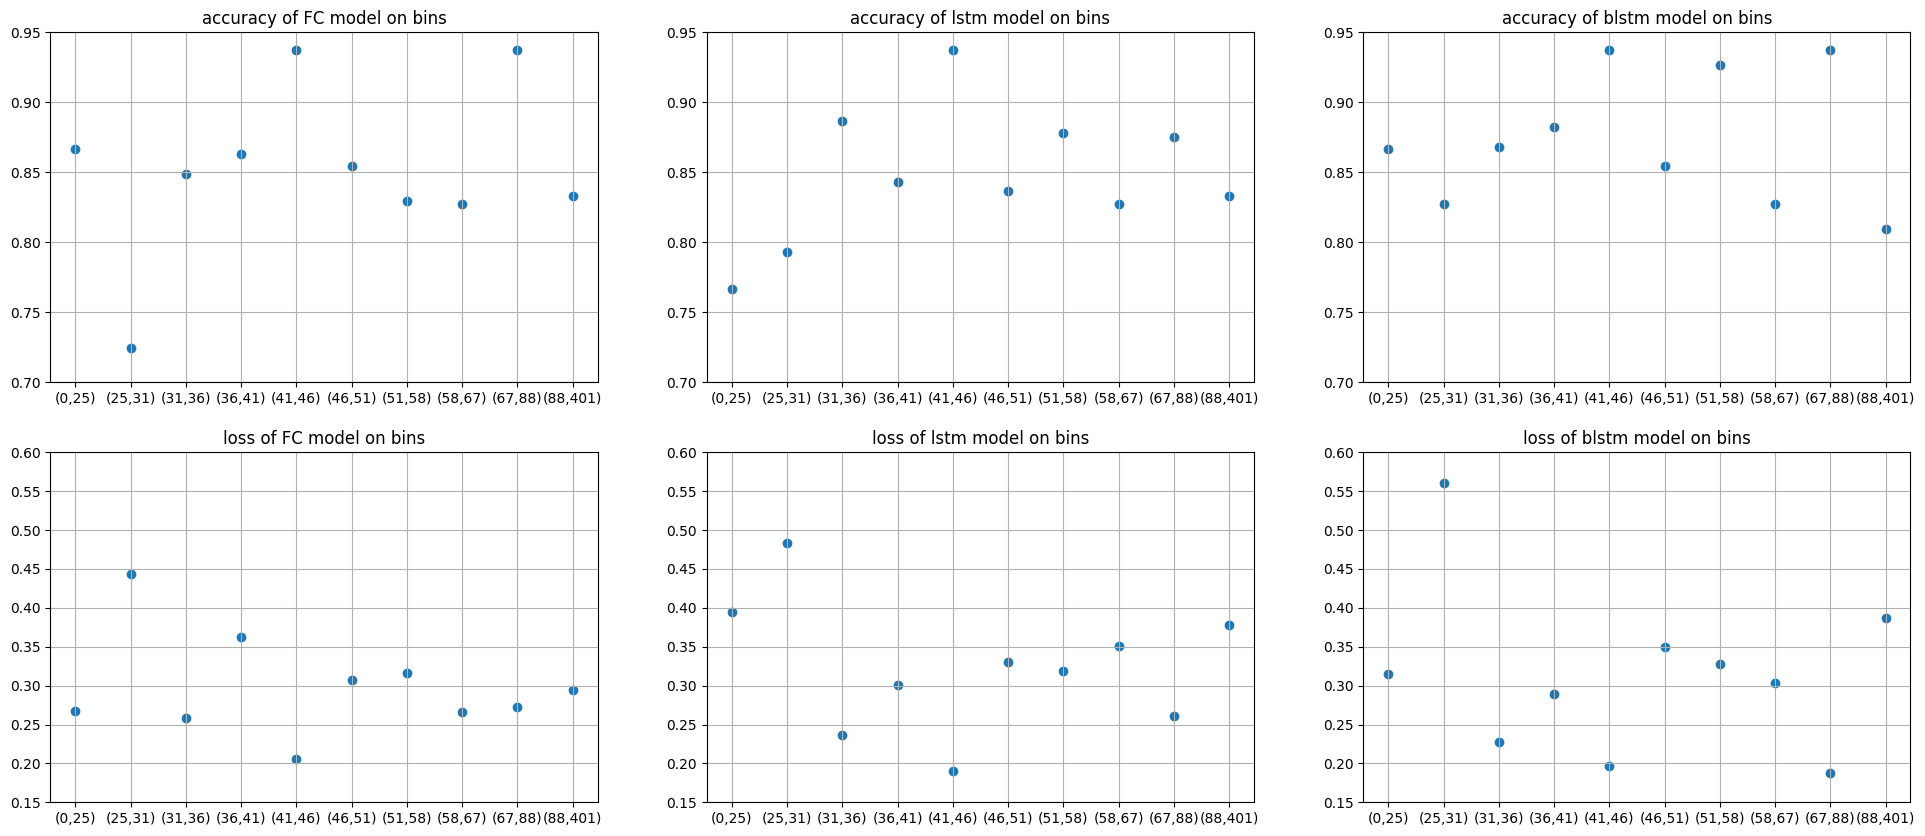

In [ ]:
x_axsis = [f'({len_split[i]},{len_split[i+1]})' for i in range(10)]
fig, ax = plt.subplots(2,3, figsize= (24,10))
ax[0,0].scatter(x_axsis , acc_fc.cpu())
ax[0,0].set_title('accuracy of FC model on bins')
ax[0,0].set_ylim((0.7, 0.95))
ax[0,0].grid()
ax[0,1].scatter(x_axsis, acc_lstm.cpu())
ax[0,1].set_title('accuracy of lstm model on bins')
ax[0,1].set_ylim((0.7, 0.95))
ax[0,1].grid()
ax[0,2].scatter(x_axsis, acc_blstm.cpu())
ax[0,2].set_title('accuracy of blstm model on bins')
ax[0,2].set_ylim((0.7, 0.95))
ax[0,2].grid()
ax[1,0].scatter(x_axsis, loss_fc.cpu())
ax[1,0].set_title('loss of FC model on bins')
ax[1,0].set_ylim((0.15, 0.6))
ax[1,0].grid()
ax[1,1].scatter(x_axsis, loss_lstm.cpu())
ax[1,1].set_title('loss of lstm model on bins')
ax[1,1].set_ylim((0.15, 0.6))
ax[1,1].grid()
ax[1,2].scatter(x_axsis, loss_blstm.cpu())
ax[1,2].set_title('loss of blstm model on bins')
ax[1,2].set_ylim((0.15, 0.6))
ax[1,2].grid()

I've split data into 10 bins and plotted accuracy and loss for all bins and for every three types of models(FC, LSTM, and BLSTM). And actually, nothing can be understood from these diagrams. No obvious pattern can be recognized by increasing the length of SMILEs except that in overall BLSTM has a better performance.